<a href="https://colab.research.google.com/github/NeelGhoshal/TwitterSentimentanalysis/blob/main/TwitterSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [9]:
df = pd.read_csv('twitterdata.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)


In [10]:
print("Dataset size:", len(df))

Dataset size: 1582


In [11]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [13]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 3.36 ms, sys: 0 ns, total: 3.36 ms
Wall time: 3.96 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

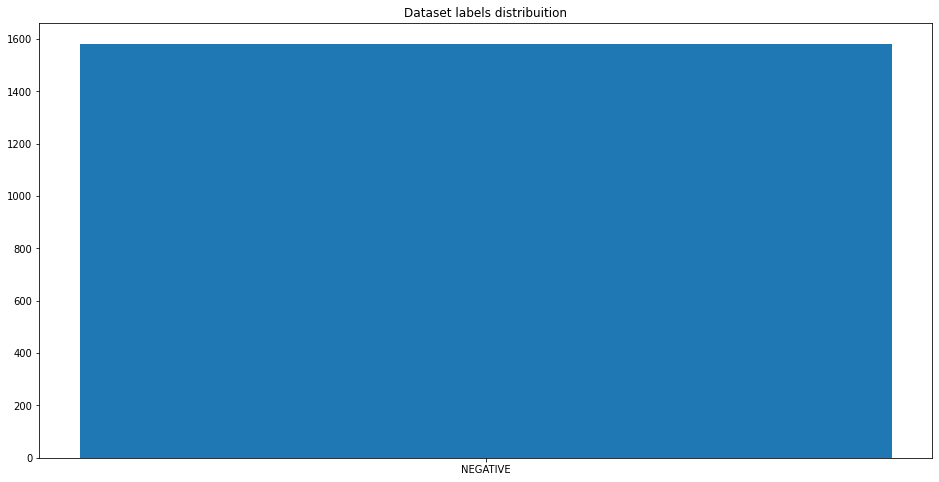

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [15]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [16]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [17]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 71.6 ms, sys: 0 ns, total: 71.6 ms
Wall time: 70.9 ms


In [18]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1265
TEST size: 317


In [19]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 3.53 ms


In [20]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [21]:
w2v_model.build_vocab(documents)

2022-01-16 13:39:47,093 : INFO : collecting all words and their counts
2022-01-16 13:39:47,095 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-16 13:39:47,108 : INFO : collected 3414 word types from a corpus of 9107 raw words and 1265 sentences
2022-01-16 13:39:47,110 : INFO : Loading a fresh vocabulary
2022-01-16 13:39:47,115 : INFO : effective_min_count=10 retains 159 unique words (4% of original 3414, drops 3255)
2022-01-16 13:39:47,118 : INFO : effective_min_count=10 leaves 3477 word corpus (38% of original 9107, drops 5630)
2022-01-16 13:39:47,122 : INFO : deleting the raw counts dictionary of 3414 items
2022-01-16 13:39:47,123 : INFO : sample=0.001 downsamples 159 most-common words
2022-01-16 13:39:47,125 : INFO : downsampling leaves estimated 1878 word corpus (54.0% of prior 3477)
2022-01-16 13:39:47,127 : INFO : estimated required memory for 159 words and 300 dimensions: 461100 bytes
2022-01-16 13:39:47,129 : INFO : resetting layer weights


In [22]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 159


In [23]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-01-16 13:39:47,214 : INFO : training model with 8 workers on 159 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2022-01-16 13:39:47,225 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-01-16 13:39:47,228 : INFO : worker thread finished; awaiting finish of 6 more threads
2022-01-16 13:39:47,229 : INFO : worker thread finished; awaiting finish of 5 more threads
2022-01-16 13:39:47,232 : INFO : worker thread finished; awaiting finish of 4 more threads
2022-01-16 13:39:47,238 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-01-16 13:39:47,240 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-01-16 13:39:47,242 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-01-16 13:39:47,243 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-01-16 13:39:47,244 : INFO : EPOCH - 1 : training on 9107 raw words (1809 effective words) took 0.0s, 81294 effective wo

CPU times: user 931 ms, sys: 113 ms, total: 1.04 s
Wall time: 1.26 s


(60325, 291424)

In [24]:
w2v_model.most_similar("love")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2022-01-16 13:39:48,492 : INFO : precomputing L2-norms of word weight vectors


[('though', 0.9998651146888733),
 ('bad', 0.9998557567596436),
 ('got', 0.9998540878295898),
 ('man', 0.9998538494110107),
 ('back', 0.9998502731323242),
 ('im', 0.9998499155044556),
 ('day', 0.9998487830162048),
 ('hope', 0.9998486638069153),
 ('3', 0.9998483657836914),
 ('least', 0.9998481273651123)]

In [25]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 3415
CPU times: user 53.2 ms, sys: 26.7 ms, total: 79.9 ms
Wall time: 85.1 ms


In [26]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 36 ms, sys: 7.01 ms, total: 43 ms
Wall time: 38.7 ms


In [27]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['NEGATIVE', 'NEUTRAL']

In [28]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1265, 1)
y_test (317, 1)


In [29]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1265, 300)
y_train (1265, 1)

x_test (317, 300)
y_test (317, 1)


In [30]:
y_train[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [31]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(3415, 300)


In [32]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [33]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          1024500   
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1,185,001
Trainable params: 160,501
Non-trainable params: 1,024,500
_________________________________________________________________


In [34]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [35]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [36]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
2/2 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.8919 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:40:09,167 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 20s 3s/step - loss: 0.6720 - accuracy: 0.8919 - val_loss: 0.5640 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/8
2/2 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:40:25,018 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 16s 2s/step - loss: 0.5735 - accuracy: 1.0000 - val_loss: 0.4577 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/8
2/2 [==============================] - ETA: 0s - loss: 0.4778 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:40:39,429 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 14s 3s/step - loss: 0.4778 - accuracy: 1.0000 - val_loss: 0.3497 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/8
2/2 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:40:53,463 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 14s 2s/step - loss: 0.3763 - accuracy: 1.0000 - val_loss: 0.2427 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/8
2/2 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:41:07,546 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 14s 2s/step - loss: 0.2744 - accuracy: 1.0000 - val_loss: 0.1400 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/8
2/2 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:41:21,453 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 14s 2s/step - loss: 0.1635 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/8
2/2 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:41:35,381 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 14s 2s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 9.2169e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 8/8
2/2 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2022-01-16 13:41:49,415 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2/2 [==============================] - 14s 2s/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 4.2179e-04 - val_accuracy: 1.0000 - lr: 0.0010
CPU times: user 3min 21s, sys: 22.2 s, total: 3min 43s
Wall time: 1min 59s


In [37]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

1/1 [==============================] - 1s 834ms/step - loss: 4.1438e-04 - accuracy: 1.0000

ACCURACY: 1.0
LOSS: 0.0004143751575611532
CPU times: user 1.43 s, sys: 155 ms, total: 1.59 s
Wall time: 881 ms


In [38]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [39]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [40]:
predict("I love the music")

{'elapsed_time': 0.4111049175262451,
 'label': 'NEGATIVE',
 'score': 0.0004950463771820068}

In [41]:
predict("I hate the rain")

{'elapsed_time': 0.1057443618774414,
 'label': 'NEGATIVE',
 'score': 0.0005012750625610352}

In [42]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.09854745864868164,
 'label': 'NEGATIVE',
 'score': 0.0003364086151123047}

In [43]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 1s 1s/step
CPU times: user 1.64 s, sys: 161 ms, total: 1.8 s
Wall time: 1.55 s


In [44]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

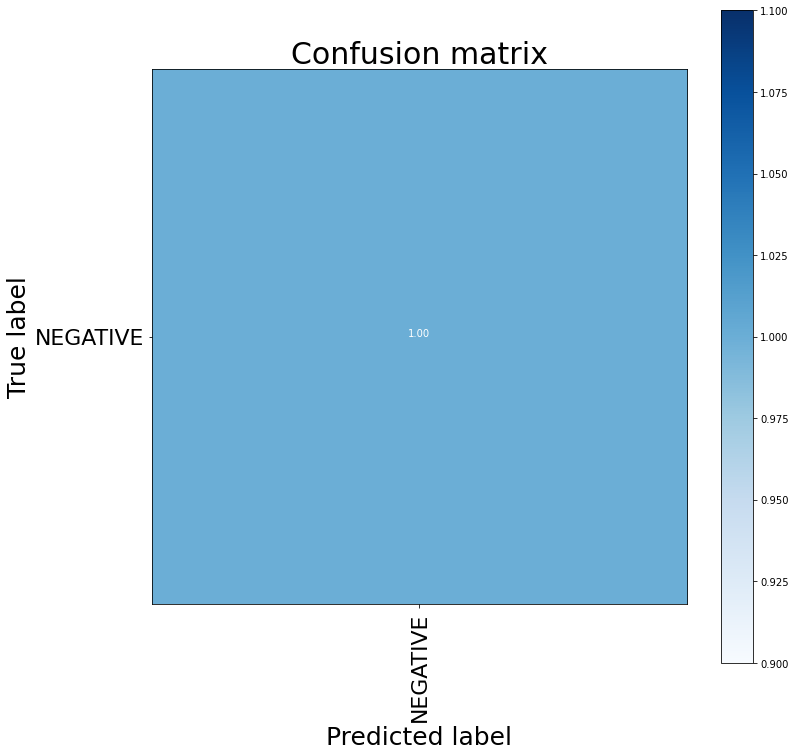

CPU times: user 267 ms, sys: 6.83 ms, total: 274 ms
Wall time: 276 ms


In [45]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [46]:
accuracy_score(y_test_1d, y_pred_1d)

1.0

In [47]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-01-16 13:41:52,955 : INFO : saving Word2Vec object under model.w2v, separately None
2022-01-16 13:41:52,956 : INFO : not storing attribute vectors_norm
2022-01-16 13:41:52,958 : INFO : not storing attribute cum_table
2022-01-16 13:41:52,972 : INFO : saved model.w2v
